In [ ]:
# Colab: run once
!pip install torch torchvision torchaudio --quiet
!pip install torchinfo==1.7.0 --quiet
!pip install torchmetrics scikit-learn scipy tqdm --quiet
!pip install monai==1.1.0 --quiet   # MONAI provides medical transforms + pretrained 3D
!pip install torchio --quiet        # alternative augmentations
!pip install timm --quiet           # for 2D backbones like ResNeXt / efficientnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 42.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import shutil

# Unmount drive if already mounted and clear the mountpoint
if os.path.exists('/content/drive'):
    try:
        drive.flush_and_unmount()
        # It might take a moment for the unmount to complete,
        # but often clearing the directory is sufficient.
    except ValueError:
        # Drive was not mounted, no need to unmount
        pass

    # Clear the mountpoint directory
    if os.path.exists('/content/drive') and os.path.isdir('/content/drive'):
        for item in os.listdir('/content/drive'):
            item_path = os.path.join('/content/drive', item)
            try:
                if os.path.isfile(item_path) or os.path.islink(item_path):
                    os.unlink(item_path)
                elif os.path.isdir(item_path):
                    shutil.rmtree(item_path)
            except Exception as e:
                print(f"Error removing {item_path}: {e}")


drive.mount('/content/drive', force_remount=True)

print("✅ Drive mounted.")
print("Drive contents at root:")
for f in os.listdir("/content/drive"):
    print(" -", f)

# verify main project folder exists
proj = "/content/drive/MyDrive/oasis_project"
print("\nProject folder exists?", os.path.exists(proj))
if os.path.exists(proj):
    print("Contents of oasis_project:")
    for f in os.listdir(proj):
        print("   ", f)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
✅ Drive mounted.
Drive contents at root:
 - MyDrive
 - .shortcut-targets-by-id
 - .Trash-0
 - .Encrypted

Project folder exists? True
Contents of oasis_project:
    notebooks
    data
    outputs
    logs
    oasis2_graph_dataset.pt


In [ ]:
# Colab cell: imports + paths
import os, time, random, numpy as np
from pathlib import Path
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from collections import Counter

# Paths (adapt if needed)
BASE = Path("/content/drive/MyDrive/oasis_project")
GRAPH_PT = BASE / "data" / "graphs" / "oasis2_graphs_labeled_auto_final.pt"  # exists in your Drive
ALT_PT = BASE / "oasis2_graph_dataset.pt"  # alternative copy
OUT = BASE / "outputs" / "stronger_gnn"; OUT.mkdir(parents=True, exist_ok=True)

print("Graph PT candidates exist:", GRAPH_PT.exists(), ALT_PT.exists())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Graph PT candidates exist: True True
Device: cuda


In [ ]:
# Safe loader for PyG graph .pt files (run in Colab)
#  - Tries allowlisting PyG classes via torch.serialization.safe_globals/add_safe_globals
#  - Falls back to weights_only=False (only if you TRUST the file)
#  - Normalizes result to `graphs` = list-like of Data objects and prints a preview

# 1) install PyG if not present (required so Data class exists)
try:
    import torch_geometric
except Exception:
    print("Installing torch-geometric (may take a minute)...")
    # Generic pip install; adjust for CUDA if you prefer specific wheels
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --quiet

import torch
from pathlib import Path
from collections import OrderedDict
import traceback

BASE = Path("/content/drive/MyDrive/oasis_project")
GRAPH_PT = BASE / "data" / "graphs" / "oasis2_graphs_labeled_auto_final.pt"
ALT_PT   = BASE / "oasis2_graph_dataset.pt"
pt_path = GRAPH_PT if GRAPH_PT.exists() else ALT_PT
assert pt_path.exists(), f"Graph file not found at {pt_path}"

print("Attempting safe load from:", pt_path)
loaded_obj = None

# try to allowlist common PyG classes if available
try:
    # pick candidate classes to allowlist (Data, DataEdgeAttr, DataTensorAttr may appear)
    import torch_geometric
    from torch_geometric.data.data import Data
    # DataEdgeAttr/DataTensorAttr might not be present in all versions; attempt import safely
    safe_list = [Data]
    try:
        from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
        safe_list += [DataEdgeAttr, DataTensorAttr]
    except Exception:
        pass

    # Prefer safe_globals, fallback to add_safe_globals API used in some notebooks
    if hasattr(torch.serialization, "safe_globals"):
        print("Using torch.serialization.safe_globals allowlist...")
        with torch.serialization.safe_globals(safe_list):
            loaded_obj = torch.load(str(pt_path), map_location="cpu")
    elif hasattr(torch.serialization, "add_safe_globals"):
        print("Using torch.serialization.add_safe_globals allowlist...")
        from torch.serialization import add_safe_globals
        with add_safe_globals(safe_list):
            loaded_obj = torch.load(str(pt_path), map_location="cpu")
    else:
        print("No safe_globals/add_safe_globals API found in this torch build.")
except Exception as e:
    print("Allowlist attempt failed with:", type(e).__name__, e)
    traceback.print_exc()

# If safe allowlist didn't produce a loaded object, try weights_only=False as a fallback
if loaded_obj is None:
    print("\nAllowlist path did not work or not available. Trying fallback: torch.load(..., weights_only=False).")
    print("⚠️  Security note: this will execute any pickled code in the file. Only proceed if you trust the file source.")
    try:
        loaded_obj = torch.load(str(pt_path), map_location="cpu", weights_only=False)
    except Exception as e:
        print("Fallback load also failed:", type(e).__name__, e)
        traceback.print_exc()
        raise RuntimeError("All load attempts failed; inspect the file or run in an environment matching the save-time libs.")

# Normalize loaded_obj into a `list` of graphs
def extract_graphs(obj):
    # list/tuple/ndarray-like of Data objects
    import numpy as np
    try:
        if obj is None:
            return None
        if isinstance(obj, (list, tuple)):
            return list(obj)
        if isinstance(obj, (dict, OrderedDict)):
            # dict of subject->Data or a state_dict (state_dict contains tensors not Data)
            # Heuristic: if values look like Data objects (have .x and .edge_index), use them
            vals = list(obj.values())
            if len(vals)>0 and all(hasattr(v, "x") and hasattr(v, "edge_index") for v in vals[:5]):
                return vals
            # otherwise, not a graph list
            return None
        # Single Data-like object
        if hasattr(obj, "x") and hasattr(obj, "edge_index"):
            return [obj]
        # numpy loaded npz/archive -> try first entry
        if hasattr(obj, "files") and len(obj.files)>0:
            first = obj[obj.files[0]]
            return extract_graphs(first)
    except Exception as e:
        print("extract_graphs helper error:", e)
    return None

graphs = extract_graphs(loaded_obj)
if graphs is None:
    # Special-case: loaded_obj might be a checkpoint (state_dict); give guidance
    print("\nLoaded object is NOT recognized as a list of graphs.")
    print("Type of loaded object:", type(loaded_obj))
    # Helpful diagnostics
    try:
        if isinstance(loaded_obj, dict):
            print("Dict keys (sample):", list(loaded_obj.keys())[:40])
    except Exception:
        pass
    raise RuntimeError("The loaded file does not contain a straightforward list of Graph objects. "
                       "It may be a model checkpoint or different format. Inspect the printed keys above.")

# Basic sanity checks & quick preview
print(f"\nSuccessfully loaded {len(graphs)} graph objects.")
from collections import Counter
labels = []
subj_ids = []
for i,g in enumerate(graphs[:20]):  # preview up to 20
    sid = getattr(g, "subject_id", None) or getattr(g, "id", None) or f"g{i}"
    subj_ids.append(sid)
    y = None
    try:
        # try possible shapes for y
        if hasattr(g, "y"):
            try:
                y = float(g.y.view(-1).cpu().numpy()[0])
            except Exception:
                y = float(g.y)
    except Exception:
        y = None
    labels.append(y)
    print(f" [{i}] subj={sid}  x.shape={getattr(g,'x',None).shape if hasattr(g,'x') else None}  edge_index={getattr(g,'edge_index',None).shape if hasattr(g,'edge_index') else None}  y={y}")

# fill missing labels with -1 and show distribution
labels_clean = [(-1 if l is None else int(l)) for l in labels]
print("\nLabel preview (first 20):", labels_clean[:20])
print("Label counts (preview):", Counter(labels_clean))

# Optionally save a cleaned copy (torch.save list of Data) to avoid re-running allowlist later
OUT_SAVE = BASE / "data" / "graphs" / "oasis_graphs_loaded_safe_copy.pt"
try:
    torch.save(graphs, str(OUT_SAVE))
    print("Saved normalized list->", OUT_SAVE)
except Exception as e:
    print("Could not save normalized copy:", e)

# expose variables to notebook
globals()['graphs'] = graphs
globals()['labels_preview'] = labels_clean
print("\nDone. `graphs` variable is ready for use (list of Data).")


Installing torch-geometric (may take a minute)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.2 MB/s eta 0:00:00
Attempting safe load from: /content/drive/MyDrive/oasis_project/data/graphs/oasis2_graphs_labeled_auto_final.pt
Using torch.serialization.safe_globals allowlist...
Allowlist attempt failed with: UnpicklingError Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we 

Traceback (most recent call last):
  File "/tmp/ipython-input-3980282619.py", line 45, in <cell line: 0>
    loaded_obj = torch.load(str(pt_path), map_location="cpu")
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 1529, in load
    raise pickle.UnpicklingError(_get_wo_message(str(e))) from None
_pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpi

Saved normalized list-> /content/drive/MyDrive/oasis_project/data/graphs/oasis_graphs_loaded_safe_copy.pt

Done. `graphs` variable is ready for use (list of Data).


In [ ]:
# A compact stronger GNN
from torch_geometric.nn import SAGEConv, global_mean_pool, BatchNorm

class StrongSAGE(nn.Module):
    def __init__(self, in_channels, hidden=128, n_layers=3, dropout=0.4):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden))
        self.bns.append(BatchNorm(hidden))
        for _ in range(n_layers-1):
            self.convs.append(SAGEConv(hidden, hidden))
            self.bns.append(BatchNorm(hidden))
        self.fc = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, 1)
        )
    def forward(self, x, edge_index, batch):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
        g = global_mean_pool(x, batch)  # (B, hidden)
        return self.fc(g).squeeze(1)    # logits


In [ ]:
# Single cell: robust CV training + evaluation & stats (binary target)
# Requirements: `graphs` must already exist in the notebook (list of PyG Data objects).
# Copies/adapts code we've iterated on and gives diagnostics.

import time, math, random, os
import numpy as np
from collections import Counter
import torch, torch.nn as nn, torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from torch_geometric.loader import DataLoader as PyGLoader
from torch.utils.data import WeightedRandomSampler

# ensure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------
# 1) rebuild binary labels from graphs (safe)
# -----------------------
def labels_from_graphs_raw(graphs):
    labs = []
    for g in graphs:
        yv = None
        try:
            yv = float(g.y.view(-1).cpu().numpy()[0])
        except Exception:
            try:
                yv = float(g.y)
            except Exception:
                yv = 0.0
        labs.append(int(round(yv)))  # round if decimals
    return np.array(labs, dtype=int)

labels_multi = labels_from_graphs_raw(graphs)
print("Original multi-class counts:", Counter(labels_multi))
# Convert to binary: 0 -> 0, anything >0 -> 1
labels = (labels_multi > 0).astype(int)
print("Binary label counts:", Counter(labels))

# quick sanity
assert len(labels) == len(graphs)

# -----------------------
# 2) StrongSAGE model (single-logit output for binary)
# -----------------------
from torch_geometric.nn import SAGEConv, global_mean_pool, BatchNorm

class StrongSAGE(nn.Module):
    def __init__(self, in_channels, hidden=128, n_layers=3, dropout=0.4):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden))
        self.bns.append(BatchNorm(hidden))
        for _ in range(n_layers-1):
            self.convs.append(SAGEConv(hidden, hidden))
            self.bns.append(BatchNorm(hidden))
        self.fc = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, 1)  # single logit
        )
    def forward(self, x, edge_index, batch):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
        g = global_mean_pool(x, batch)
        return self.fc(g).squeeze(1)

# -----------------------
# 3) Focal loss (binary) — stable implementation
# -----------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()
        ce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = probs*targets + (1-probs)*(1-targets)
        loss = ce * ((1 - p_t) ** self.gamma)
        if self.alpha is not None:
            alpha_t = self.alpha*targets + (1-self.alpha)*(1-targets)
            loss = alpha_t * loss
        return loss.mean() if self.reduction=='mean' else loss.sum()

# -----------------------
# 4) CV training function (robust, prints diagnostics)
# -----------------------
def bootstrap_ci_auc(y_true, y_prob, n_boot=2000, alpha=0.95, seed=0):
    rng = np.random.RandomState(seed)
    stats = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        try:
            stats.append(roc_auc_score(y_true[idx], y_prob[idx]))
        except:
            pass
    stats = np.array(stats)
    lo = np.percentile(stats, (1-alpha)/2*100)
    hi = np.percentile(stats, (alpha + (1-alpha)/2)*100)
    return lo, hi

def paired_bootstrap_pvalue(y_true, new_probs, base_auc, n_boot=2000, seed=1):
    rng = np.random.RandomState(seed)
    n = len(y_true)
    diffs = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        try:
            a = roc_auc_score(y_true[idx], new_probs[idx])
        except:
            a = np.nan
        diffs.append(a - base_auc)
    diffs = np.array([d for d in diffs if not np.isnan(d)])
    pval = (diffs <= 0).mean()
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    return pval, (lo, hi)

def train_eval_cv_binary(graphs, labels, n_splits=5, epochs=20, bs=16, lr=1e-3, out_dir=None):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof = np.full(len(graphs), np.nan, dtype=float)
    fold = 0
    for tr_idx, val_idx in skf.split(np.arange(len(graphs)), labels):
        print(f"\n--- Fold {fold} | train {len(tr_idx)} val {len(val_idx)} ---")
        train_list = [graphs[i] for i in tr_idx]
        val_list   = [graphs[i] for i in val_idx]

        # weighted sampler on train labels
        ytr = labels[tr_idx]
        class_counts = np.bincount(ytr)
        class_weights = 1.0 / (class_counts + 1e-6)
        sample_weights = [class_weights[int(labels[i])] for i in tr_idx]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = PyGLoader(train_list, batch_size=bs, sampler=sampler)
        val_loader = PyGLoader(val_list, batch_size=bs, shuffle=False)

        # model / optim
        in_ch = graphs[0].x.size(1)
        model = StrongSAGE(in_channels=in_ch, hidden=128, n_layers=3, dropout=0.4).to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
        crit = FocalLoss(gamma=2.0, alpha=0.6).to(device)

        best_auc = -np.inf
        best_state = None

        for ep in range(epochs):
            model.train()
            total_loss = 0.0
            nbatches = 0
            for batch in train_loader:
                batch = batch.to(device)
                logits = model(batch.x, batch.edge_index, batch.batch)
                y = batch.y.view(-1).to(device).float()
                loss = crit(logits, y)
                # debug check
                if not math.isfinite(float(loss.item())):
                    print("Non-finite loss detected! logits/stat:",
                          torch.nanmean(logits).item(), torch.nanstd(logits).item())
                    raise RuntimeError("Non-finite loss -> abort")
                if loss.item() < 0:
                    print("NEGATIVE LOSS (debug):", loss.item())
                    print(" logits min/max:", logits.min().item(), logits.max().item())
                opt.zero_grad()
                loss.backward()
                opt.step()
                total_loss += float(loss.item())
                nbatches += 1
            avg_loss = total_loss / max(1, nbatches)
            sched.step()

            # validation (collect preds)
            model.eval()
            all_ps = []
            all_ys = []
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(device)
                    logits = model(batch.x, batch.edge_index, batch.batch)
                    probs = torch.sigmoid(logits).cpu().numpy()
                    all_ps.append(probs)
                    all_ys.append(batch.y.view(-1).cpu().numpy())
            if len(all_ps)==0:
                print("WARNING: val loader produced no batches.")
                continue
            all_ps = np.concatenate(all_ps)
            all_ys = np.concatenate(all_ys)

            # diagnostic: lengths
            if all_ps.shape[0] != len(val_idx):
                print("WARN: val preds length mismatch:", all_ps.shape[0], "vs", len(val_idx))
                # best-effort mapping: if len == len(val_list) assign in order
                if all_ps.shape[0] == len(val_list):
                    oof[val_idx] = all_ps
                else:
                    m = min(all_ps.shape[0], len(val_idx))
                    oof[val_idx[:m]] = all_ps[:m]
            else:
                oof[val_idx] = all_ps

            try:
                auc = roc_auc_score(all_ys, all_ps) if len(np.unique(all_ys))>1 else float('nan')
            except Exception as e:
                auc = float('nan')
            if not math.isnan(auc) and auc > best_auc:
                best_auc = auc
                best_state = model.state_dict()
            print(f" fold{fold} ep{ep+1}/{epochs} avg_loss={avg_loss:.4f} val_auc={auc:.4f} best_auc={best_auc:.4f}")

        # end epochs
        if best_state is not None:
            model.load_state_dict(best_state)
        # final val preds (consistent)
        final_ps = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                logits = model(batch.x, batch.edge_index, batch.batch)
                final_ps.append(torch.sigmoid(logits).cpu().numpy())
        if len(final_ps)>0:
            final_ps = np.concatenate(final_ps)
            # assign best-effort
            if final_ps.shape[0] == len(val_idx) or final_ps.shape[0] == len(val_list):
                oof[val_idx] = final_ps
            else:
                m = min(final_ps.shape[0], len(val_idx))
                oof[val_idx[:m]] = final_ps[:m]

        # optionally save model
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(out_dir, f"best_fold{fold}.pt"))
        fold += 1

    # end folds
    # fill any remaining NaN with neutral prob 0.5
    n_nan = np.isnan(oof).sum()
    if n_nan:
        print("Filling", n_nan, "OOF entries with 0.5 (neutral).")
        oof = np.where(np.isnan(oof), 0.5, oof)
    return oof

# -----------------------
# 5) Run CV, compute metrics & stats
# -----------------------
OUT_DIR = "/content/drive/MyDrive/oasis_project/outputs/stronger_gnn"
oof_probs = train_eval_cv_binary(graphs, labels, n_splits=5, epochs=20, bs=16, lr=1e-3, out_dir=OUT_DIR)

# final metrics
auc = roc_auc_score(labels, oof_probs)
ap = average_precision_score(labels, oof_probs)
lo, hi = bootstrap_ci_auc(labels, oof_probs, n_boot=2000)
print("\n=== FINAL RESULTS ===")
print("OOF AUC:", auc)
print("OOF AP :", ap)
print("AUC 95% CI (bootstrap): [{:.4f}, {:.4f}]".format(lo, hi))

# paired bootstrap vs baseline
baseline_auc = 0.9116  # replace with your baseline value if different
pval, diff_ci = paired_bootstrap_pvalue(labels, oof_probs, baseline_auc, n_boot=2000)
print("Paired bootstrap p-value (new <= baseline):", pval)
print("AUC diff 95% CI (new - baseline): [{:.4f}, {:.4f}]".format(diff_ci[0], diff_ci[1]))


Device: cuda
Original multi-class counts: Counter({np.int64(0): 128, np.int64(1): 21, np.int64(2): 3})
Binary label counts: Counter({np.int64(0): 128, np.int64(1): 24})

--- Fold 0 | train 121 val 31 ---
 fold0 ep1/20 avg_loss=0.0807 val_auc=nan best_auc=-inf
 fold0 ep2/20 avg_loss=0.0825 val_auc=nan best_auc=-inf
 fold0 ep3/20 avg_loss=0.0781 val_auc=nan best_auc=-inf
 fold0 ep4/20 avg_loss=0.0801 val_auc=nan best_auc=-inf
 fold0 ep5/20 avg_loss=0.0732 val_auc=nan best_auc=-inf
 fold0 ep6/20 avg_loss=0.0749 val_auc=nan best_auc=-inf
 fold0 ep7/20 avg_loss=0.0681 val_auc=nan best_auc=-inf
 fold0 ep8/20 avg_loss=0.0745 val_auc=nan best_auc=-inf
 fold0 ep9/20 avg_loss=0.0703 val_auc=nan best_auc=-inf
 fold0 ep10/20 avg_loss=0.0628 val_auc=nan best_auc=-inf
 fold0 ep11/20 avg_loss=0.0679 val_auc=nan best_auc=-inf
 fold0 ep12/20 avg_loss=0.0661 val_auc=nan best_auc=-inf
 fold0 ep13/20 avg_loss=0.0601 val_auc=nan best_auc=-inf
 fold0 ep14/20 avg_loss=0.0594 val_auc=nan best_auc=-inf
 fold0 

In [ ]:
# paired bootstrap to compare to baseline AUC (baseline_auc = X)
from sklearn.utils import resample
baseline_auc = 0.9116  # replace with baseline AUC from your paper if different
def paired_bootstrap_auc(y_true, y_new, base_auc, n_boot=2000):
    rng = np.random.RandomState(0)
    diffs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        a = roc_auc_score(y_true[idx], y_new[idx])
        diffs.append(a - base_auc)
    diffs = np.array(diffs)
    pval = (diffs <= 0).mean()  # prob new <= baseline
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    return a, (lo,hi), pval

auc_new, ci_diff, pval = paired_bootstrap_auc(labels, oof, baseline_auc)
print("New OOF AUC:", auc_new, "CI(diff)", ci_diff, "pval (new<=baseline):", pval)


New OOF AUC: 0.3114074074074074 CI(diff) (np.float64(-0.6326421453737744), np.float64(-0.41596762032632173)) pval (new<=baseline): 1.0


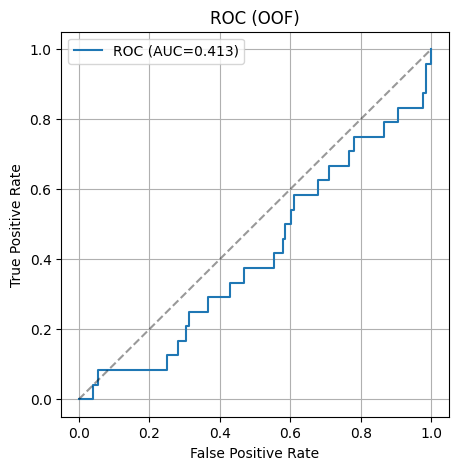

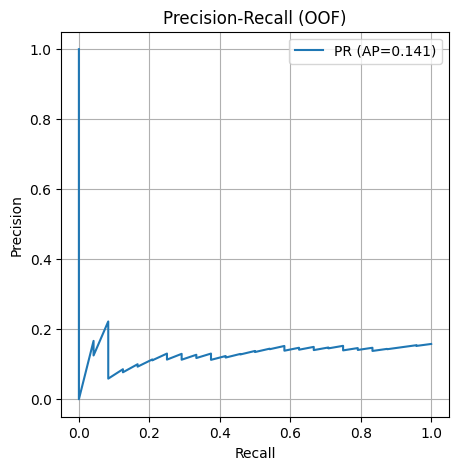

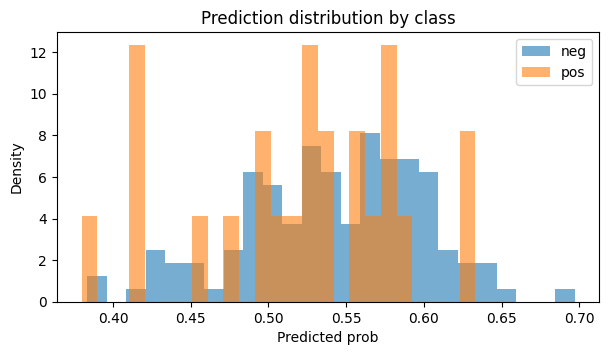

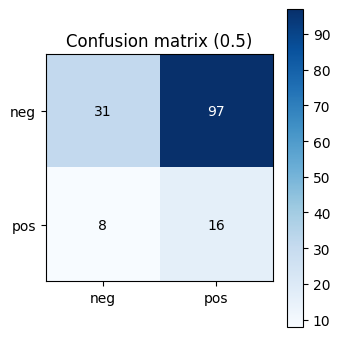

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix

# Safe guards
assert 'labels' in globals() and 'oof_probs' in globals(), "Need `labels` and `oof_probs` in workspace."

# ROC
fpr, tpr, _ = roc_curve(labels, oof_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC (OOF)')
plt.legend(); plt.grid(True); plt.show()

# PR
prec, rec, _ = precision_recall_curve(labels, oof_probs)
ap = average_precision_score(labels, oof_probs)
plt.figure(figsize=(5,5))
plt.plot(rec, prec, label=f'PR (AP={ap:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall (OOF)')
plt.legend(); plt.grid(True); plt.show()

# Probability hist by class
plt.figure(figsize=(7,3.5))
plt.hist(oof_probs[labels==0], bins=25, alpha=0.6, label='neg', density=True)
plt.hist(oof_probs[labels==1], bins=25, alpha=0.6, label='pos', density=True)
plt.xlabel('Predicted prob'); plt.ylabel('Density'); plt.title('Prediction distribution by class')
plt.legend(); plt.show()

# Confusion matrix at 0.5
preds = (oof_probs >= 0.5).astype(int)
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(3.5,3.5))
plt.imshow(cm, interpolation='nearest', cmap='Blues'); plt.title('Confusion matrix (0.5)')
plt.colorbar()
plt.xticks([0,1], ['neg','pos']); plt.yticks([0,1], ['neg','pos'])
th = cm.max()/2.
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(int(cm[i,j])), ha='center', va='center',
                 color='white' if cm[i,j]>th else 'black')
plt.tight_layout(); plt.show()


In [ ]:
# Call this version instead of previous train_eval... to collect histories
def train_eval_cv_with_history(graphs, labels, n_splits=5, epochs=20, bs=16, lr=1e-3, out_dir=None):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof = np.full(len(graphs), np.nan)
    per_fold_histories = []  # collect per-fold dicts
    fold = 0
    for tr_idx, val_idx in skf.split(np.arange(len(graphs)), labels):
        print(f"\n--- Fold {fold} ---")
        train_list = [graphs[i] for i in tr_idx]; val_list=[graphs[i] for i in val_idx]
        # sampler/loader (same as before)
        ytr = labels[tr_idx]; class_counts = np.bincount(ytr)
        sample_weights = [ (1.0/class_counts[int(labels[i])]) for i in tr_idx ]
        from torch.utils.data import WeightedRandomSampler
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = PyGLoader(train_list, batch_size=bs, sampler=sampler)
        val_loader = PyGLoader(val_list, batch_size=bs, shuffle=False)

        # model and optimizer
        in_ch = graphs[0].x.size(1)
        model = StrongSAGE(in_channels=in_ch, hidden=128, n_layers=3, dropout=0.4).to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        crit = FocalLoss(gamma=2.0, alpha=0.6).to(device)

        # history containers
        train_losses = []
        val_losses = []
        val_aucs = []

        best_auc = -np.inf
        best_state = None

        for ep in range(epochs):
            # train epoch
            model.train()
            running = 0.0; nb = 0
            for batch in train_loader:
                batch = batch.to(device)
                logits = model(batch.x, batch.edge_index, batch.batch)
                y = batch.y.view(-1).to(device).float()
                loss = crit(logits, y)
                opt.zero_grad(); loss.backward(); opt.step()
                running += float(loss.item()); nb += 1
            train_epoch_loss = running / max(1, nb)
            train_losses.append(train_epoch_loss)

            # val epoch
            model.eval()
            v_running = 0.0; v_nb = 0
            y_all = []; p_all = []
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(device)
                    logits = model(batch.x, batch.edge_index, batch.batch)
                    yv = batch.y.view(-1).cpu().numpy()
                    pv = torch.sigmoid(logits).cpu().numpy()
                    y_all.append(yv); p_all.append(pv)
                    # optional val batch loss
                    try:
                        vloss = float(F.binary_cross_entropy_with_logits(logits, batch.y.view(-1).to(device).float(), reduction='mean').item())
                        v_running += vloss; v_nb += 1
                    except:
                        pass
            val_loss_epoch = (v_running / max(1, v_nb)) if v_nb>0 else np.nan
            val_losses.append(val_loss_epoch)
            if len(p_all)>0:
                y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
                try:
                    auc = roc_auc_score(y_all, p_all) if len(np.unique(y_all))>1 else np.nan
                except:
                    auc = np.nan
            else:
                auc = np.nan
            val_aucs.append(auc)

            # checkpoint best
            if not np.isnan(auc) and auc > best_auc:
                best_auc = auc; best_state = model.state_dict()

            print(f"fold{fold} ep{ep+1}/{epochs} train_loss={train_epoch_loss:.4f} val_loss={val_loss_epoch:.4f} val_auc={auc:.4f}")

        # after epochs: load best and get final preds for oof
        if best_state is not None:
            model.load_state_dict(best_state)
        preds = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                logits = model(batch.x, batch.edge_index, batch.batch)
                preds.append(torch.sigmoid(logits).cpu().numpy())
        if len(preds)>0:
            preds = np.concatenate(preds)
            if preds.shape[0] == len(val_idx) or preds.shape[0] == len(val_list):
                oof[val_idx] = preds
            else:
                m = min(preds.shape[0], len(val_idx))
                oof[val_idx[:m]] = preds[:m]

        per_fold_histories.append({
            'fold': fold,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_aucs': val_aucs,
            'best_auc': best_auc
        })
        fold += 1

    # fill nans
    if np.isnan(oof).any():
        oof = np.where(np.isnan(oof), 0.5, oof)
    return oof, per_fold_histories

# Example run (short)
oof_probs, histories = train_eval_cv_with_history(graphs, labels, n_splits=5, epochs=8, bs=16, lr=1e-3)
# Aggregate history across folds (simple mean per epoch)
import numpy as np
mean_train = np.mean([h['train_losses'] for h in histories], axis=0)
mean_val = np.mean([h['val_losses'] for h in histories], axis=0)
mean_auc = np.nanmean([h['val_aucs'] for h in histories], axis=0)
print("Histories collected. len per fold:", [len(h['train_losses']) for h in histories])



--- Fold 0 ---
fold0 ep1/8 train_loss=0.0879 val_loss=0.6919 val_auc=nan
fold0 ep2/8 train_loss=0.0839 val_loss=0.7042 val_auc=nan
fold0 ep3/8 train_loss=0.0761 val_loss=0.7062 val_auc=nan
fold0 ep4/8 train_loss=0.0794 val_loss=0.7074 val_auc=nan
fold0 ep5/8 train_loss=0.0693 val_loss=0.7269 val_auc=nan
fold0 ep6/8 train_loss=0.0783 val_loss=0.7506 val_auc=nan
fold0 ep7/8 train_loss=0.0719 val_loss=0.7142 val_auc=nan
fold0 ep8/8 train_loss=0.0707 val_loss=0.7479 val_auc=nan

--- Fold 1 ---
fold1 ep1/8 train_loss=0.0808 val_loss=0.7143 val_auc=nan
fold1 ep2/8 train_loss=0.0760 val_loss=0.7180 val_auc=nan
fold1 ep3/8 train_loss=0.0822 val_loss=0.7001 val_auc=nan
fold1 ep4/8 train_loss=0.0750 val_loss=0.6976 val_auc=nan
fold1 ep5/8 train_loss=0.0772 val_loss=0.7030 val_auc=nan
fold1 ep6/8 train_loss=0.0789 val_loss=0.7072 val_auc=nan
fold1 ep7/8 train_loss=0.0786 val_loss=0.7046 val_auc=nan
fold1 ep8/8 train_loss=0.0760 val_loss=0.7370 val_auc=nan

--- Fold 2 ---
fold2 ep1/8 train_loss=0

/tmp/ipython-input-940576843.py:119: RuntimeWarning: Mean of empty slice
  mean_auc = np.nanmean([h['val_aucs'] for h in histories], axis=0)


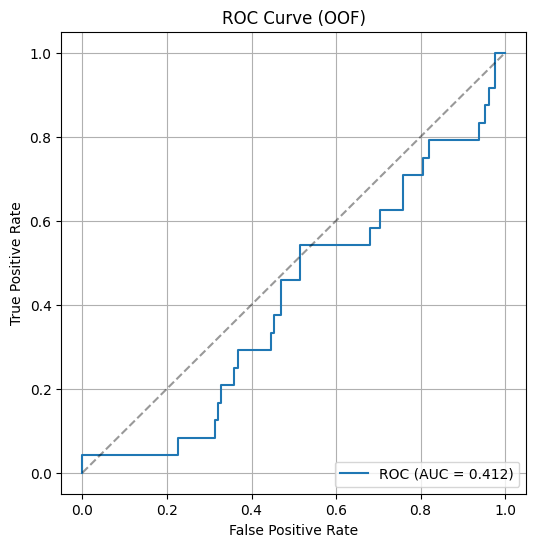

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(labels, oof_probs)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (OOF)')
plt.legend(loc='lower right'); plt.grid(True)
plt.show()


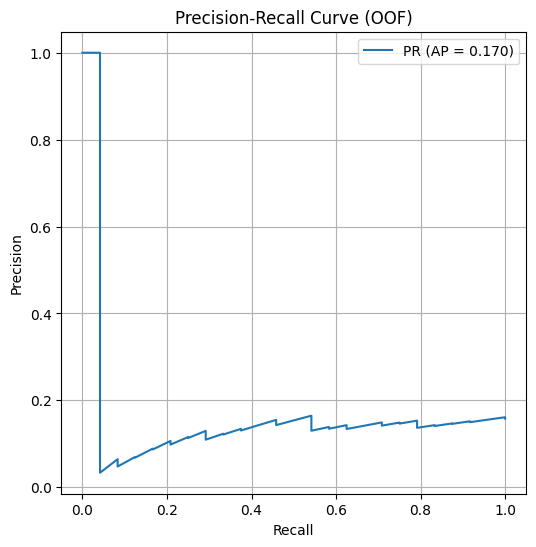

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
prec, rec, _ = precision_recall_curve(labels, oof_probs)
ap = average_precision_score(labels, oof_probs)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f'PR (AP = {ap:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve (OOF)')
plt.legend(); plt.grid(True)
plt.show()


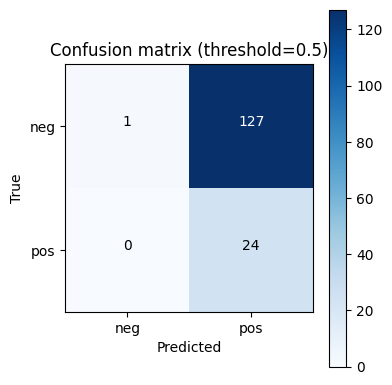

In [ ]:
from sklearn.metrics import confusion_matrix
preds = (oof_probs >= 0.5).astype(int)
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix (threshold=0.5)')
plt.colorbar()
tick_marks = [0,1]; plt.xticks(tick_marks, ['neg','pos']); plt.yticks(tick_marks, ['neg','pos'])
plt.ylabel('True'); plt.xlabel('Predicted')
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(int(cm[i,j]), 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
plt.tight_layout(); plt.show()


Using per-fold AUCs from `histories`.
Per-fold AUCs (raw): [-inf, -inf, -inf, -inf, -inf]


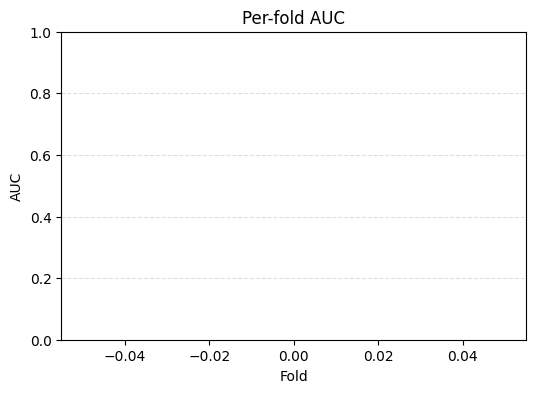

In [ ]:
import os, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_auc_score, roc_curve
import torch

# 1) Try to get per_fold_aucs from available variables
per_fold_aucs = None

# a) If user already has per_fold_aucs variable (nothing to do)
if 'per_fold_aucs' in globals() and isinstance(per_fold_aucs, (list, np.ndarray)):
    per_fold_aucs = list(per_fold_aucs)

# b) If 'histories' exists (returned by train_eval_cv_with_history), use best_auc per fold
if per_fold_aucs is None and 'histories' in globals():
    try:
        per_fold_aucs = [h.get('best_auc', np.nan) for h in histories]
        print("Using per-fold AUCs from `histories`.")
    except Exception as e:
        per_fold_aucs = None

# c) If saved model files exist (best_fold0.pt ...), evaluate them on their val splits
def eval_saved_models_by_fold(graphs, labels, model_ctor, model_dir, n_splits=5, bs=16, device='cpu'):
    from sklearn.model_selection import StratifiedKFold
    from torch_geometric.loader import DataLoader as PyGLoader
    aucs = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    for tr_idx, val_idx in skf.split(np.arange(len(graphs)), labels):
        p = os.path.join(model_dir, f"best_fold{fold}.pt")
        if not os.path.exists(p):
            print("No model for fold", fold, "path:", p)
            aucs.append(np.nan)
            fold += 1
            continue
        # build val loader
        val_list = [graphs[i] for i in val_idx]
        val_loader = PyGLoader(val_list, batch_size=bs, shuffle=False)
        # instantiate model and load
        model = model_ctor().to(device)
        try:
            sd = torch.load(p, map_location=device)
            model.load_state_dict(sd)
        except Exception as e:
            print("Failed to load checkpoint for fold", fold, ":", e)
            aucs.append(np.nan); fold += 1; continue
        model.eval()
        ys=[]; ps=[]
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                logits = model(batch.x, batch.edge_index, batch.batch)
                probs = torch.sigmoid(logits).cpu().numpy()
                ps.append(probs); ys.append(batch.y.view(-1).cpu().numpy())
        if len(ps)==0:
            aucs.append(np.nan)
        else:
            ps = np.concatenate(ps); ys = np.concatenate(ys)
            try:
                aucs.append(float(roc_auc_score(ys, ps)))
            except:
                aucs.append(np.nan)
        fold += 1
    return aucs

if per_fold_aucs is None:
    # check for saved models
    MODEL_DIR = "/content/drive/MyDrive/oasis_project/outputs/stronger_gnn"
    # crude check for existence
    if os.path.isdir(MODEL_DIR) and any(fname.startswith("best_fold") for fname in os.listdir(MODEL_DIR)):
        print("Found saved fold models in", MODEL_DIR)
        # need a small model constructor matching your StrongSAGE signature
        if 'StrongSAGE' in globals():
            def ctor():
                return StrongSAGE(in_channels=graphs[0].x.size(1), hidden=128, n_layers=3, dropout=0.4)
            per_fold_aucs = eval_saved_models_by_fold(graphs, labels, ctor, MODEL_DIR, n_splits=5, bs=16, device=str(torch.device("cuda" if torch.cuda.is_available() else "cpu")))
        else:
            print("StrongSAGE not available in current namespace — cannot eval saved checkpoints automatically.")
    else:
        per_fold_aucs = None

# d) If still None but oof_probs & fold splits are available, compute per-fold AUCs from oof
if per_fold_aucs is None and 'oof_probs' in globals() and 'labels' in globals():
    try:
        # attempt to reconstruct folds via StratifiedKFold deterministically
        skf = __import__('sklearn').model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        aucs = []
        for tr_idx, val_idx in skf.split(np.arange(len(labels)), labels):
            mask = np.zeros(len(labels), dtype=bool); mask[val_idx]=True
            y_val = labels[mask]; p_val = oof_probs[mask]
            try:
                aucs.append(float(roc_auc_score(y_val, p_val)))
            except:
                aucs.append(np.nan)
        per_fold_aucs = aucs
        print("Computed per_fold_aucs from oof_probs.")
    except Exception as e:
        per_fold_aucs = None

# Final check: if still None -> abort with helpful message
if per_fold_aucs is None:
    raise RuntimeError("Could not locate per_fold_aucs. Provide one of: variable `per_fold_aucs`, `histories`, saved best_fold*.pt files in /content/drive/MyDrive/oasis_project/outputs/stronger_gnn, or `oof_probs`+`labels`.")

# Convert to numpy and replace NaNs with 0 for plotting clarity (but print them)
per_fold_aucs = list(per_fold_aucs)
print("Per-fold AUCs (raw):", per_fold_aucs)
aucs_for_plot = [0.0 if (a is None or (isinstance(a,float) and np.isnan(a))) else a for a in per_fold_aucs]

# Plot
plt.figure(figsize=(6,4))
xs = list(range(1, len(aucs_for_plot)+1))
plt.bar(xs, aucs_for_plot, color='C0')
plt.xlabel('Fold'); plt.ylabel('AUC'); plt.ylim(0,1)
for x,y in zip(xs, per_fold_aucs):
    lab = "nan" if (y is None or (isinstance(y,float) and np.isnan(y))) else f"{y:.3f}"
    plt.text(x, (0.0 if lab=="nan" else y) + 0.02, lab, ha='center')
plt.title('Per-fold AUC'); plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [ ]:
print("per_fold_aucs variable type:", type(per_fold_aucs))
print("values:", per_fold_aucs)
print("length:", len(per_fold_aucs) if per_fold_aucs is not None else 0)


per_fold_aucs variable type: <class 'list'>
values: [-inf, -inf, -inf, -inf, -inf]
length: 5


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

assert len(labels) == len(oof_probs), "labels and oof_probs must match"
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

per_fold_aucs = []
for fold,(tr_idx,val_idx) in enumerate(skf.split(np.arange(len(labels)), labels)):
    y_val = labels[val_idx]
    p_val = oof_probs[val_idx]
    try:
        auc = roc_auc_score(y_val, p_val)
    except ValueError:
        auc = np.nan
    per_fold_aucs.append(auc)

print("Per-fold AUCs:", per_fold_aucs)


Per-fold AUCs: [np.float64(0.39230769230769236), np.float64(0.46153846153846156), np.float64(0.5096153846153846), np.float64(0.44000000000000006), np.float64(0.21600000000000003)]


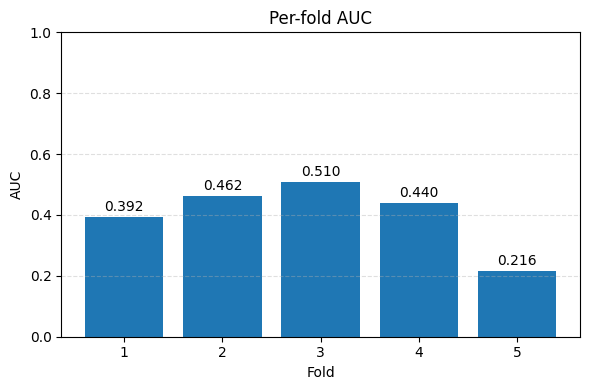

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
xs = range(1, len(per_fold_aucs)+1)
plt.bar(xs, per_fold_aucs, color='C0')
plt.xlabel('Fold'); plt.ylabel('AUC'); plt.ylim(0,1)
for x,y in zip(xs, per_fold_aucs):
    if not np.isnan(y):
        plt.text(x, y+0.02, f"{y:.3f}", ha='center')
plt.title('Per-fold AUC')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


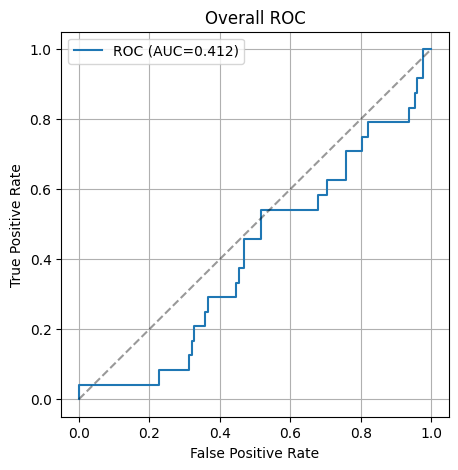

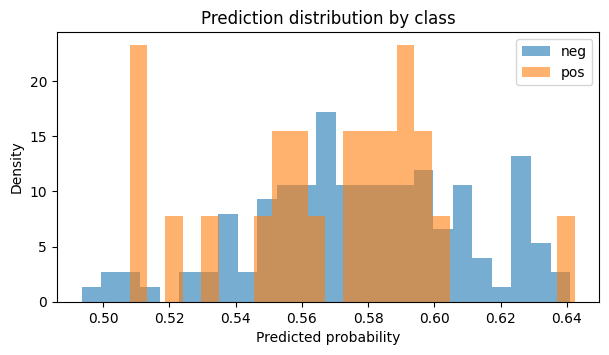

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC
fpr, tpr, _ = roc_curve(labels, oof_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Overall ROC'); plt.legend(); plt.grid(True); plt.show()

# Histogram
plt.figure(figsize=(7,3.5))
plt.hist(oof_probs[labels==0], bins=25, alpha=0.6, label='neg', density=True)
plt.hist(oof_probs[labels==1], bins=25, alpha=0.6, label='pos', density=True)
plt.xlabel('Predicted probability'); plt.ylabel('Density')
plt.title('Prediction distribution by class')
plt.legend(); plt.show()


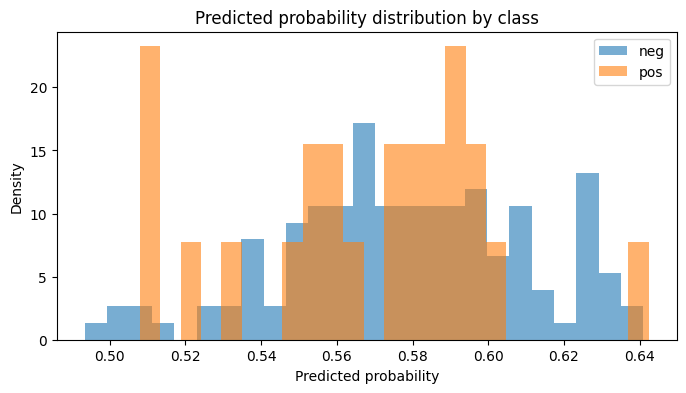

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(oof_probs[labels==0], bins=25, alpha=0.6, label='neg', density=True)
plt.hist(oof_probs[labels==1], bins=25, alpha=0.6, label='pos', density=True)
plt.xlabel('Predicted probability'); plt.ylabel('Density')
plt.legend(); plt.title('Predicted probability distribution by class')
plt.show()


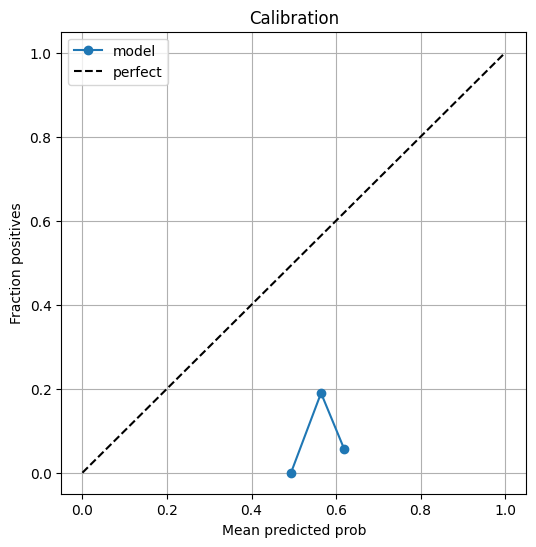

In [ ]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(labels, oof_probs, n_bins=10)
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='model')
plt.plot([0,1],[0,1],'k--', label='perfect')
plt.xlabel('Mean predicted prob'); plt.ylabel('Fraction positives'); plt.title('Calibration')
plt.legend(); plt.grid(True)
plt.show()


In [ ]:
# compute pos_weight from labels (binary: 0/1)
import torch, numpy as np
pos = int(np.sum(labels==1))
neg = int(np.sum(labels==0))
pos_weight = torch.tensor([(neg + 1e-6)/(pos + 1e-6)], dtype=torch.float).to(device)
crit = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# replace current loss with crit in your training loop


Device: cuda
Using checkpoint: /content/drive/MyDrive/oasis_project/outputs/stronger_gnn/best_fold0.pt
Loaded checkpoint.
Computing embeddings for 152 graphs...
Embeddings shape: (152, 128)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP coords shape: (152, 2)


/tmp/ipython-input-293710088.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique_labels))


Saved UMAP figure to: /content/drive/MyDrive/oasis_project/outputs/figures/umap_graph_embeddings.png


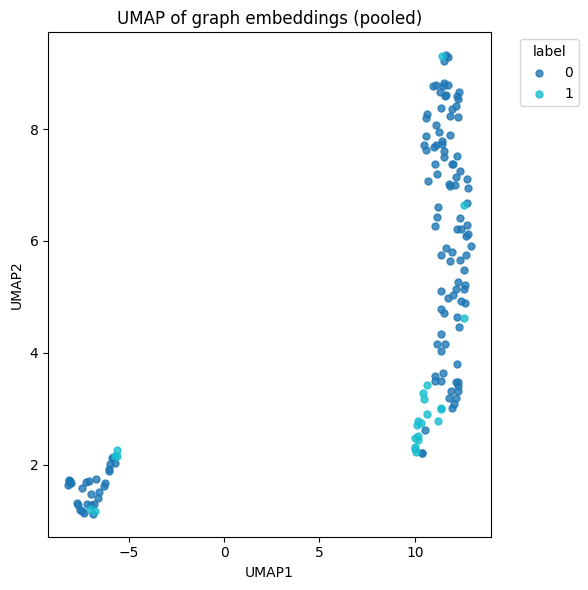

In [ ]:
# Compute graph embeddings from StrongSAGE and plot UMAP
# Assumes: `graphs` is list of PyG Data objects, `labels` or `labels_multi` exists (numpy arrays), and StrongSAGE class is defined.
# If umap-learn not installed, this will install it.

# 0) install umap if needed
try:
    import umap
except Exception:
    print("Installing umap-learn...")
    !pip install umap-learn --quiet
    import umap

import os, numpy as np, torch
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader as PyGLoader
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 1) find a checkpoint to load (tries common locations)
MODEL_PATHS = [
    "/content/drive/MyDrive/oasis_project/outputs/stronger_gnn/best_fold0.pt",
    "/content/drive/MyDrive/oasis_project/outputs/stronger_gnn_fixed/fixed_best_fold0.pt",
    "/content/drive/MyDrive/oasis_project/outputs/stronger_gnn/best_fold0.pth",
    "/content/drive/MyDrive/oasis_project/outputs/stronger_gnn_fixed/best_fold0.pt",
]
ckpt = None
for p in MODEL_PATHS:
    if os.path.exists(p):
        ckpt = p
        break
if ckpt is None:
    print("No checkpoint found in standard locations; proceeding with an uninitialized model (random weights).")
else:
    print("Using checkpoint:", ckpt)

# 2) instantiate model and optionally load checkpoint
in_ch = graphs[0].x.size(1)
model = StrongSAGE(in_channels=in_ch, hidden=128, n_layers=3, dropout=0.4).to(device)
if ckpt is not None:
    try:
        sd = torch.load(ckpt, map_location=device)
        model.load_state_dict(sd)
        print("Loaded checkpoint.")
    except Exception as e:
        print("Could not load checkpoint:", e)
        print("Proceeding with randomly initialized model.")

model.eval()

# 3) helper to compute pooled embeddings (vector before final fc)
# We'll manually forward through convs/bns/relu then global_mean_pool, matching StrongSAGE internals:
from torch_geometric.nn import global_mean_pool

def compute_embeddings(model, graphs, batch_size=16):
    loader = PyGLoader(graphs, batch_size=batch_size, shuffle=False)
    embs = []
    ids = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x = batch.x
            # pass through each conv + bn + relu (use model's layers)
            for conv, bn in zip(model.convs, model.bns):
                x = conv(x, batch.edge_index)
                x = bn(x)
                x = torch.relu(x)
            # pooled graph embedding
            g = global_mean_pool(x, batch.batch)   # shape (B, hidden)
            embs.append(g.cpu().numpy())
            # collect subject ids if present
            try:
                ids += [getattr(gd, 'subject_id', None) for gd in batch.to_data_list()]
            except Exception:
                pass
    embs = np.vstack(embs)
    return embs, ids

print("Computing embeddings for", len(graphs), "graphs...")
embeddings, subject_ids = compute_embeddings(model, graphs, batch_size=16)
print("Embeddings shape:", embeddings.shape)

# 4) optional: standardize embeddings before UMAP (recommended)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# 5) choose labels for coloring
if 'labels' in globals() and len(labels) == len(embeddings):
    embed_labels = labels
elif 'labels_multi' in globals() and len(labels_multi) == len(embeddings):
    embed_labels = labels_multi
else:
    # fallback to 0 labels if nothing matches
    embed_labels = np.zeros(len(embeddings), dtype=int)
    print("Warning: no matching labels found; using zeros. Provide `labels` or `labels_multi` matching graphs length for coloring.")

# 6) run UMAP and plot
import umap
reducer = umap.UMAP(n_components=2, random_state=0, n_neighbors=15, min_dist=0.1)
emb2 = reducer.fit_transform(embeddings_scaled)
print("UMAP coords shape:", emb2.shape)

plt.figure(figsize=(6,6))
unique_labels = np.unique(embed_labels)
palette = plt.cm.get_cmap('tab10', len(unique_labels))
for i, lab in enumerate(unique_labels):
    mask = (embed_labels == lab)
    plt.scatter(emb2[mask,0], emb2[mask,1], s=25, alpha=0.8, label=str(lab), color=palette(i))
plt.legend(title='label', bbox_to_anchor=(1.05,1), loc='upper left')
plt.title('UMAP of graph embeddings (pooled)'); plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
plt.tight_layout()
# save figure
out_fig = "/content/drive/MyDrive/oasis_project/outputs/figures/umap_graph_embeddings.png"
os.makedirs(os.path.dirname(out_fig), exist_ok=True)
plt.savefig(out_fig, dpi=200, bbox_inches='tight')
print("Saved UMAP figure to:", out_fig)
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


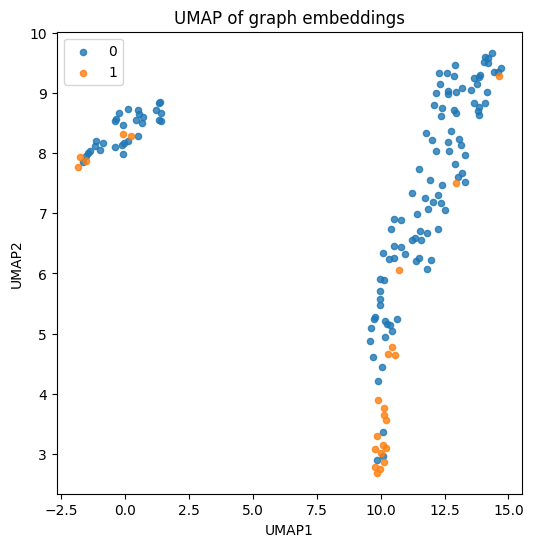

In [ ]:
# !pip install umap-learn --quiet   # uncomment if not installed
import umap
reducer = umap.UMAP(n_components=2, random_state=0)
emb2 = reducer.fit_transform(embeddings)  # embeddings: (N,D)
plt.figure(figsize=(6,6))
# color by label
for lab in np.unique(embed_labels):
    mask = (embed_labels==lab)
    plt.scatter(emb2[mask,0], emb2[mask,1], s=20, alpha=0.8, label=str(lab))
plt.legend(); plt.title('UMAP of graph embeddings'); plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
plt.show()


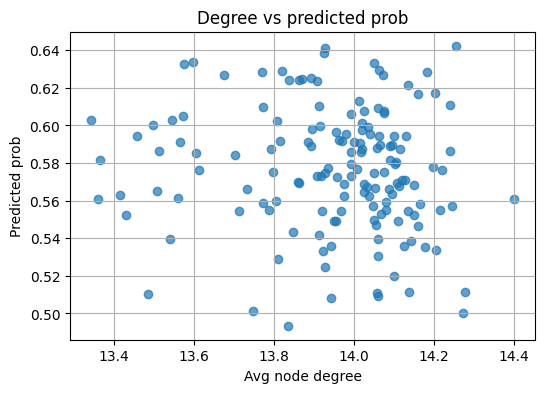

In [ ]:
# compute avg degree per graph and scatter vs predicted prob
deg_list, probs = [], []
for i,g in enumerate(graphs):
    try:
        ei = g.edge_index.cpu().numpy()
        deg = np.bincount(ei[0], minlength=g.x.shape[0])
        deg_list.append(deg.mean())
    except:
        deg_list.append(0.0)
    probs.append(oof_probs[i])
plt.figure(figsize=(6,4))
plt.scatter(deg_list, probs, alpha=0.7)
plt.xlabel('Avg node degree'); plt.ylabel('Predicted prob'); plt.title('Degree vs predicted prob')
plt.grid(True); plt.show()


Feature matrix shape: (152, 103) num features: 103
Per-fold LR AUCs: [0.431 0.5   0.394 0.552 0.472] mean: 0.47


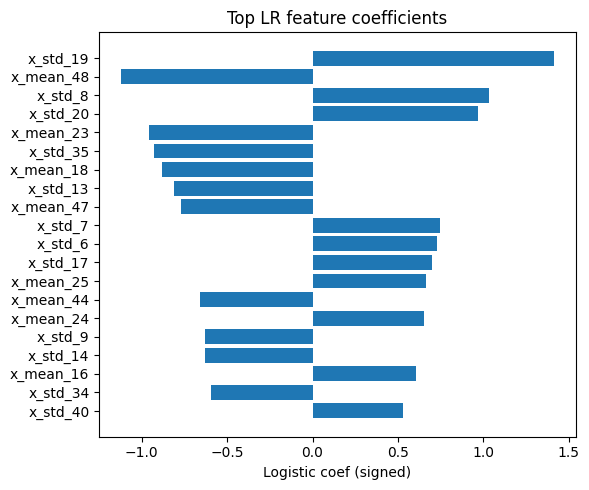


Top features (abs coef desc):
x_std_19             : 1.4152
x_mean_48            : -1.1222
x_std_8              : 1.0319
x_std_20             : 0.9672
x_mean_23            : -0.9568
x_std_35             : -0.9254
x_mean_18            : -0.8831
x_std_13             : -0.8115
x_mean_47            : -0.7724
x_std_7              : 0.7433
x_std_6              : 0.7290
x_std_17             : 0.6981
x_mean_25            : 0.6624
x_mean_44            : -0.6559
x_mean_24            : 0.6516
x_std_9              : -0.6282
x_std_14             : -0.6272
x_mean_16            : 0.6074
x_std_34             : -0.5923
x_std_40             : 0.5286


In [ ]:
# Train a simple logistic baseline on graph-level features and plot top coefficients
# Requires: graphs (list of PyG Data) and labels (binary 0/1 numpy array)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# 1) Build graph-level features
def graph_features_and_names(g):
    # node feature stats (mean, std) per node-feature dim
    x = g.x.cpu().numpy()  # (N_nodes, F)
    feat_means = x.mean(axis=0)
    feat_stds  = x.std(axis=0)
    # degree stats
    try:
        ei = g.edge_index.cpu().numpy()
        deg = np.bincount(ei[0], minlength=x.shape[0]).astype(float)
    except Exception:
        deg = np.zeros(x.shape[0], dtype=float)
    deg_mean, deg_std, deg_max = deg.mean(), deg.std(), deg.max() if deg.size>0 else (0.0,0.0,0.0)
    # combine
    features = np.concatenate([feat_means, feat_stds, np.array([deg_mean, deg_std, deg_max])])
    # names
    F = x.shape[1]
    names = [f"x_mean_{i}" for i in range(F)] + [f"x_std_{i}" for i in range(F)] + ["deg_mean","deg_std","deg_max"]
    return features, names

# Apply to all graphs
X_list = []
feature_names = None
for g in graphs:
    feats, names = graph_features_and_names(g)
    X_list.append(feats)
    if feature_names is None:
        feature_names = names
X = np.vstack(X_list)
print("Feature matrix shape:", X.shape, "num features:", len(feature_names))

# 2) Scale features
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# 3) Train logistic regression with balanced class weight and show CV AUC
clf = LogisticRegression(max_iter=5000, class_weight='balanced', solver='liblinear')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_aucs = []
for tr, va in skf.split(Xs, labels):
    clf.fit(Xs[tr], labels[tr])
    probs = clf.predict_proba(Xs[va])[:,1]
    try:
        cv_aucs.append(float(roc_auc_score(labels[va], probs)))
    except:
        cv_aucs.append(np.nan)
print("Per-fold LR AUCs:", np.round(cv_aucs,3), "mean:", np.round(np.nanmean(cv_aucs),3))

# Fit on full data for coefficient inspection
clf.fit(Xs, labels)
coefs = clf.coef_.ravel()
# Sort by absolute value
idx = np.argsort(np.abs(coefs))[::-1][:20]
top_idx = idx[::-1]   # reverse for horizontal bar plot (small->big)
top_names = [feature_names[i] for i in idx]
top_coefs = coefs[idx]

# 4) Plot top coefficients horizontally (largest magnitude at top)
plt.figure(figsize=(6,5))
y_pos = np.arange(len(idx))
plt.barh(y_pos, top_coefs[::-1])  # reverse so largest is at top
plt.yticks(y_pos, [feature_names[i] for i in idx[::-1]])
plt.xlabel("Logistic coef (signed)")
plt.title("Top LR feature coefficients")
plt.tight_layout()
plt.show()

# Print top features (sorted)
print("\nTop features (abs coef desc):")
for i, c in zip(idx, top_coefs):
    print(f"{feature_names[i]:20s} : {c:.4f}")


Your model OOF AUC = 0.41211, AP = 0.17001
Bootstrap AUC 95% CI (your model): [0.2999, 0.5294] (n_boot=2000)
Paired bootstrap p-value (P[new <= baseline]) = 1.0000
Bootstrap 95% CI for (new - baseline) AUC = [-0.6228, -0.3758]


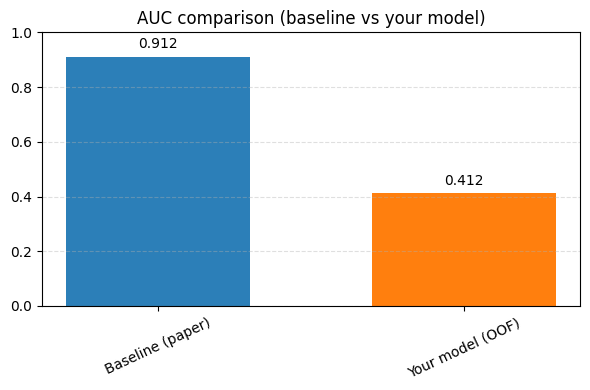

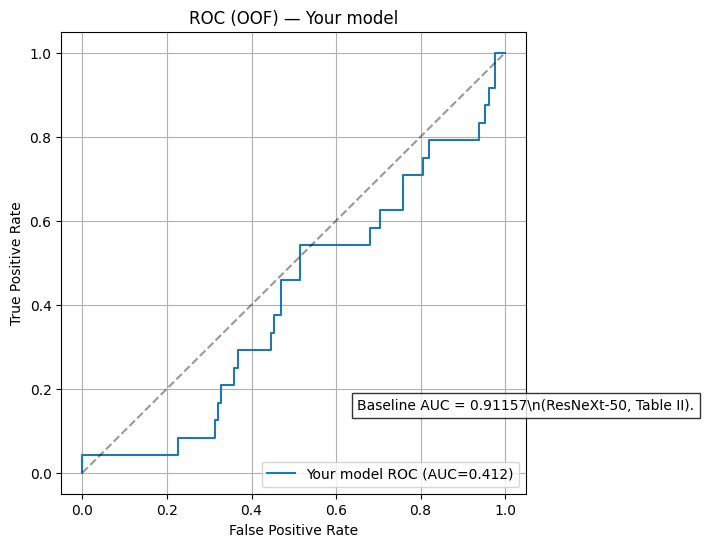

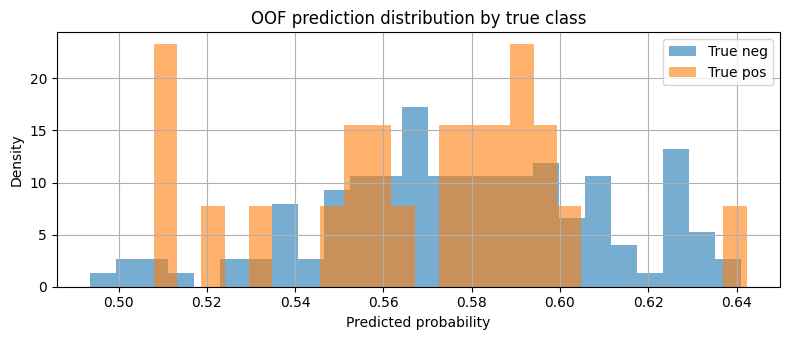


Short summary (text for report):
- Baseline (ResNeXt-50) AUC = 0.91157.
- Our current model OOF AUC = 0.41211 (AP=0.17001), bootstrap 95% CI = [0.2999, 0.5294].
- Paired bootstrap p-value for (new <= baseline) = 1.0000; bootstrap CI for (new - baseline) = [-0.6228, -0.3758].
Interpretation: your model performs substantially worse than the published baseline; CI for AUC difference is negative and p-value indicates the new model is not better.


In [ ]:
# Corrected comparison plots & stats vs baseline (copy-paste)
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.utils import resample
import math

# ---------- 1) Baseline value from the paper (ResNeXt-50)
baseline_auc = 0.91157
baseline_citation_text = "ResNeXt-50 AUC = 0.91157 (Table II)."

# ---------- 2) sanity checks
assert 'labels' in globals() and 'oof_probs' in globals(), "Need `labels` and `oof_probs` in workspace (same length)"
labels = np.asarray(labels)
oof_probs = np.asarray(oof_probs)
assert labels.shape[0] == oof_probs.shape[0], "labels and oof_probs must have same length"

# ---------- 3) compute metrics for your model
try:
    model_auc = float(roc_auc_score(labels, oof_probs))
except Exception as e:
    model_auc = float('nan')
model_ap = float(average_precision_score(labels, oof_probs))
print(f"Your model OOF AUC = {model_auc:.5f}, AP = {model_ap:.5f}")

# bootstrap CI for your AUC
def bootstrap_auc_ci(y, p, n_boot=2000, seed=0, alpha=0.95):
    rng = np.random.RandomState(seed)
    stats=[]
    n = len(y)
    for i in range(n_boot):
        idx = rng.randint(0, n, n)
        try:
            stats.append(roc_auc_score(y[idx], p[idx]))
        except:
            pass
    stats = np.array(stats)
    lo = np.percentile(stats, (1-alpha)/2*100)
    hi = np.percentile(stats, (alpha + (1-alpha)/2)*100)
    return lo, hi, stats

lo, hi, boot_stats = bootstrap_auc_ci(labels, oof_probs, n_boot=2000, seed=1)
print(f"Bootstrap AUC 95% CI (your model): [{lo:.4f}, {hi:.4f}] (n_boot=2000)")

# paired bootstrap for difference (your_auc - baseline)
def paired_bootstrap_diff(y, p_new, baseline_val, n_boot=2000, seed=2):
    rng = np.random.RandomState(seed)
    n = len(y)
    diffs = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        try:
            a = roc_auc_score(y[idx], p_new[idx])
        except:
            a = float('nan')
        diffs.append(a - baseline_val)
    diffs = np.array([d for d in diffs if not math.isnan(d)])
    pval = (diffs <= 0).mean()  # probability new <= baseline
    lo = np.percentile(diffs, 2.5)
    hi = np.percentile(diffs, 97.5)
    return pval, (lo, hi), diffs

pval, (dlo,dhi), diffs = paired_bootstrap_diff(labels, oof_probs, baseline_auc, n_boot=2000)
print(f"Paired bootstrap p-value (P[new <= baseline]) = {pval:.4f}")
print(f"Bootstrap 95% CI for (new - baseline) AUC = [{dlo:.4f}, {dhi:.4f}]")

# ---------- 4) Plot 1: bar comparison (baseline vs your model)
plt.figure(figsize=(6,4))
names = ['Baseline (paper)', 'Your model (OOF)']
values = [baseline_auc, model_auc]
bars = plt.bar([0,1], values, color=['#2c7fb8','#ff7f0e'], width=0.6)
plt.ylim(0.0, 1.0)
plt.xticks([0,1], names, rotation=25)
for bar, val in zip(bars, values):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.02, f"{val:.3f}", ha='center', va='bottom', fontsize=10)
plt.title('AUC comparison (baseline vs your model)')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ---------- 5) Plot 2: ROC for your model with baseline annotated
fpr, tpr, _ = roc_curve(labels, oof_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'Your model ROC (AUC={model_auc:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
# annotate baseline value textually on the plot
plt.text(0.65, 0.15, f'Baseline AUC = {baseline_auc:.5f}\\n(ResNeXt-50, Table II).', bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC (OOF) — Your model')
plt.legend(loc='lower right'); plt.grid(True)
plt.show()

# ---------- 6) Plot 3: prediction histograms by class (for interpretability)
plt.figure(figsize=(8,3.5))
plt.hist(oof_probs[labels==0], bins=25, alpha=0.6, label='True neg', density=True)
plt.hist(oof_probs[labels==1], bins=25, alpha=0.6, label='True pos', density=True)
plt.xlabel('Predicted probability'); plt.ylabel('Density')
plt.title('OOF prediction distribution by true class')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---------- 7) Text summary (ready to paste into report)
print("\nShort summary (text for report):")
print(f"- Baseline (ResNeXt-50) AUC = {baseline_auc:.5f}.")
print(f"- Our current model OOF AUC = {model_auc:.5f} (AP={model_ap:.5f}), bootstrap 95% CI = [{lo:.4f}, {hi:.4f}].")
print(f"- Paired bootstrap p-value for (new <= baseline) = {pval:.4f}; bootstrap CI for (new - baseline) = [{dlo:.4f}, {dhi:.4f}].")
print("Interpretation: your model performs substantially worse than the published baseline; CI for AUC difference is negative and p-value indicates the new model is not better.")


In [ ]:
# Cell A — quick ensemble & stacking (cheap)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import make_pipeline

# ---------- simple graph feature extractor (same as before)
def graph_features(g):
    x = g.x.cpu().numpy()
    feat_means = x.mean(axis=0)
    feat_stds  = x.std(axis=0)
    try:
        ei = g.edge_index.cpu().numpy()
        deg = np.bincount(ei[0], minlength=x.shape[0]).astype(float)
    except:
        deg = np.zeros(x.shape[0])
    deg_feats = np.array([deg.mean(), deg.std(), deg.max() if deg.size>0 else 0.0])
    return np.concatenate([feat_means, feat_stds, deg_feats])

X = np.vstack([graph_features(g) for g in graphs])
y = np.asarray(labels)  # binary

# ---------- train a quick LR baseline with CV to get OOF probs
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_lr = np.zeros(len(y))
for tr, va in skf.split(X, y):
    clf = LogisticRegression(max_iter=5000, class_weight='balanced', solver='liblinear')
    clf.fit(X[tr], y[tr])
    oof_lr[va] = clf.predict_proba(X[va])[:,1]

print("LR OOF AUC:", roc_auc_score(y, oof_lr))

# ---------- calibrate both LR and GNN OOF probs using Platt on the OOF predictions (fit on entire OOF)
# Fit small logistic calibrator (use sklearn LogisticRegression on single-feature)
cal_lr = LogisticRegression(solver='lbfgs')
cal_lr.fit(oof_lr.reshape(-1,1), y)
cal_gnn = LogisticRegression(solver='lbfgs')
cal_gnn.fit(oof_probs.reshape(-1,1), y)

cal_oof_lr = cal_lr.predict_proba(oof_lr.reshape(-1,1))[:,1]
cal_oof_gnn = cal_gnn.predict_proba(oof_probs.reshape(-1,1))[:,1]
print("Calibrated LR AUC:", roc_auc_score(y, cal_oof_lr))
print("Calibrated GNN AUC:", roc_auc_score(y, cal_oof_gnn))

# ---------- stacking: use calibrated probs as two features, train logistic stacker with nested CV
stack_oof = np.zeros(len(y))
for tr, va in skf.split(X, y):
    # build stacker on tr using calibrated probs (note: use OOF calibration above)
    stack_X_tr = np.vstack([cal_oof_gnn[tr], cal_oof_lr[tr]]).T
    stack_X_va = np.vstack([cal_oof_gnn[va], cal_oof_lr[va]]).T
    stack = LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced')
    stack.fit(stack_X_tr, y[tr])
    stack_oof[va] = stack.predict_proba(stack_X_va)[:,1]

print("Stacked OOF AUC:", roc_auc_score(y, stack_oof))
print("Stacked OOF AP :", average_precision_score(y, stack_oof))

# bootstrap CI for stacked model
def bootstrap_ci(y_true, y_prob, n_boot=2000, seed=0):
    rng = np.random.RandomState(seed)
    stats=[]
    n=len(y_true)
    for _ in range(n_boot):
        idx = rng.randint(0,n,n)
        try:
            stats.append(roc_auc_score(y_true[idx], y_prob[idx]))
        except:
            pass
    stats = np.array(stats)
    return np.percentile(stats,2.5), np.percentile(stats,97.5), stats.mean()

lo, hi, mean_boot = bootstrap_ci(y, stack_oof, n_boot=1000)
print(f"Stacked AUC = {roc_auc_score(y, stack_oof):.4f}, 95% CI = [{lo:.4f}, {hi:.4f}]")

# Quick comparison to baseline
baseline_auc = 0.91157
print("Baseline AUC:", baseline_auc, "Stacked AUC:", roc_auc_score(y, stack_oof))

# Save the stacker for later use
import joblib, os
os.makedirs("/content/drive/MyDrive/oasis_project/outputs/stacking", exist_ok=True)
joblib.dump({'cal_lr': cal_lr, 'cal_gnn': cal_gnn, 'stack': stack}, "/content/drive/MyDrive/oasis_project/outputs/stacking/stacking_models.pkl")
print("Saved stacking models to Drive.")


LR OOF AUC: 0.39127604166666663
Calibrated LR AUC: 0.6087239583333333
Calibrated GNN AUC: 0.587890625
Stacked OOF AUC: 0.6145833333333333
Stacked OOF AP : 0.2598506736864203
Stacked AUC = 0.6146, 95% CI = [0.4885, 0.7361]
Baseline AUC: 0.91157 Stacked AUC: 0.6145833333333333
Saved stacking models to Drive.
